In [1]:
import numpy as np
x = np.load('./data/AAL_tangent_correlation.npy')  # Shape
y = np.load('./data/Y.npy')  # Assuming shape: (871,)

print(x.shape)
print(y.shape)

(871, 116, 116)
(871,)


In [2]:
num_graphs, num_nodes, _ = x.shape
print(x.shape)
num_features = num_nodes * (num_nodes - 1) // 2   

print("num_graphs:", num_graphs)   
print("num_nodes:", num_nodes)    
print("num_features:", num_features)  

# Build a list mapping each “feature index” [0..E] → an (i,j) pair in the upper triangle
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]
# Now edge_pairs[k] gives the (i,j) for that k in [0..num_features-1]

(871, 116, 116)
num_graphs: 871
num_nodes: 116
num_features: 6670


In [3]:
num_selected = int(0.20 * num_features)  # 20% of 6670= 1334 indices
num_trials = 500  # number of repetitions.
num_epochs = 30  # number of training epochs per trial. \

# Create arrays to store each trial's selected indices and accuracy.
# The indices array is shaped as (num_selected, num_trials), where each column represents one trial.
indices_matrix = np.zeros((num_selected, num_trials), dtype=int)
accuracy_vector = np.zeros(num_trials)

In [4]:
import torch
from torch_geometric.data import Data

def generate_multiple_graphs(X, y):
    """
    Generate multiple PyTorch Geometric graph objects from full symmetric adjacency matrices.
    
    Parameters:
        X (numpy.ndarray): 3D array of shape (num_graphs, N_nodes, N_nodes) where each entry is an adjacency matrix.
        y (numpy.ndarray): 1D array of graph labels.
    
    Returns:
        List[Data]: A list of PyTorch Geometric Data objects.
    """
    graphs = []
    num_graphs = X.shape[0]
    N_nodes = X.shape[1] # Assuming square adjacency matrices

    for graph_idx in range(num_graphs):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]

        # Initialize node features,edge index and weight.
        node_features = [[1,] for _ in range(N_nodes)]
        edge_index = []
        edge_weight = []

        # Iterate over upper triangle to avoid self-loops and duplicate edges
        for i in range(N_nodes):
            for j in range(i + 1, N_nodes): # Avoiding self-loops and duplicate edges
                weight = adjacency_matrix[i, j]
                if weight != 0: # Only include edges with non-zero weight
                    # Add both (i, j) and (j, i) for undirected graph
                    edge_index.append([i, j])
                    edge_weight.append(weight) # I removed the additional edge_index since the graph is undirected. 
                                       
                    # Update node features by accumulating connected edge weights
                    node_features[i][0] += weight
                    node_features[j][0] += weight

        # Convert lists to PyTorch tensors
        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.tensor([], dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=label_tensor)
        graphs.append(data)
                     
    return graphs

In [5]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool

class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        # 1st GATv2 layer: input_dim → hidden_dim, using 'heads' attention heads
        # edge_dim=1 since each edge has one feature (FC weight)
        self.gat1 = GATv2Conv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.3,
            edge_dim=1
        )
        # 2nd GATv2 layer: (hidden_dim * heads) → hidden_dim
        self.gat2 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.3,
            edge_dim=1
        )
        # 3rd GATv2 layer: (hidden_dim * heads) → output_dim, single head, no concat
        self.gat3 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=output_dim,
            heads=1,
            concat=False,
            dropout=0.3,
            edge_dim=1
        )
        # Final linear layer for binary classification
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Reshape edge_weight from (E,) → (E, 1)
        ew = edge_weight.view(-1, 1)

        # 1) Apply first GATv2 + ReLU
        x = F.relu(self.gat1(x, edge_index, ew))
        # 2) Apply second GATv2 + ReLU
        x = F.relu(self.gat2(x, edge_index, ew))
        # 3) Apply third GATv2 (no activation)
        x = self.gat3(x, edge_index, ew)
        # 4) Global mean pool over nodes → one graph vector
        x = global_mean_pool(x, batch)
        # 5) Linear layer + sigmoid for binary output
        x = self.fc(x)
        return torch.sigmoid(x)

In [6]:
def train(model, loader, optimizer, criterion):
    # Train the model for one epoch over the given data loader
    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        # Forward pass
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        # Compute loss (reshape output to match labels)
        loss = criterion(out.squeeze(1), data.y.float())
        # Backward pass and weight update
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Return the average loss per batch
    return total_loss / len(loader)


def evaluate(model, loader):
    # Compute overall accuracy of the model on the provided data loader
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            # Convert probabilities to binary predictions (threshold = 0.5)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

    # Return the fraction of correctly classified graphs
    return correct / total


def eval_loss(model, loader, criterion):
    # Compute the average loss of the model over all graphs in the loader
    model.eval()
    total_loss = 0.0
    total_graphs = 0

    with torch.no_grad():
        for data in loader:
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            # Compute loss for this batch, weighted by number of graphs
            loss = criterion(out.squeeze(1), data.y.float())
            total_loss += loss.item() * data.num_graphs
            total_graphs += data.num_graphs

    # Return the average loss per graph
    return total_loss / total_graphs

In [7]:
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split

for trial in range(num_trials):
    print(f"Trial {trial+1}/{num_trials}")

    # 1) Randomly select 20% of the 6670 upper‐triangle “features” (each maps to one (i,j) pair)
    selected_feat_idxs = np.random.choice(num_features, size=num_selected, replace=False)
    indices_matrix[:, trial] = selected_feat_idxs  # Save selected indices for this trial

    # 2) Create a modified copy of the full (871, 116, 116) FC matrices
    X_mod = x.copy()  # x.shape 

    #    Zero out each chosen edge (i,j) and its mirror (j,i) across all subjects
    for feat_idx in selected_feat_idxs:
        i, j = edge_pairs[feat_idx]
        X_mod[:, i, j] = 0.0
        X_mod[:, j, i] = 0.0

    # 3) Generate PyG graphs from the masked FC matrices
    graphs = generate_multiple_graphs(X_mod, y)

    # 4) Split graphs into train/val/test (80/10/10)
    dataset_size = len(graphs)
    train_size   = int(0.8 * dataset_size)
    val_size     = int(0.1 * dataset_size)
    test_size    = dataset_size - train_size - val_size
    train_data, val_data, test_data = random_split(graphs, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_data,   batch_size=32)
    test_loader  = DataLoader(test_data,  batch_size=32)

    # 5) Initialize model, loss, optimizer, and scheduler
    model     = GraphAttentionModel(input_dim=1, hidden_dim=16, output_dim=2)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # 6) Training loop 
    best_val_loss    = float('inf')
    best_model_state = None
    wait             = 0
    patience         = 10

    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss   = eval_loss(model, val_loader, criterion)
        val_acc    = evaluate(model, val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch:02d} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss    = val_loss
            best_model_state = model.state_dict()
            wait             = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"--> Early stopping at epoch {epoch} (no val_loss improvement in {patience} epochs)")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 7) Test‐set evaluation
    test_acc = evaluate(model, test_loader)
    accuracy_vector[trial] = test_acc
    print(f"Trial {trial+1} Test Acc: {test_acc:.4f}")

Trial 1/500


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 01 — Train Loss: 0.7070, Val Loss: 0.7185, Val Acc: 0.5172
Epoch 02 — Train Loss: 0.7027, Val Loss: 0.7150, Val Acc: 0.5172
Epoch 03 — Train Loss: 0.6996, Val Loss: 0.7117, Val Acc: 0.5172
Epoch 04 — Train Loss: 0.6947, Val Loss: 0.7093, Val Acc: 0.5172
Epoch 05 — Train Loss: 0.6967, Val Loss: 0.7069, Val Acc: 0.5172
Epoch 06 — Train Loss: 0.6937, Val Loss: 0.7049, Val Acc: 0.5172
Epoch 07 — Train Loss: 0.6929, Val Loss: 0.7036, Val Acc: 0.5172
Epoch 08 — Train Loss: 0.6918, Val Loss: 0.7021, Val Acc: 0.5172
Epoch 09 — Train Loss: 0.6921, Val Loss: 0.7011, Val Acc: 0.5172
Epoch 10 — Train Loss: 0.6922, Val Loss: 0.7001, Val Acc: 0.5172
Epoch 11 — Train Loss: 0.6923, Val Loss: 0.6991, Val Acc: 0.5172
Epoch 12 — Train Loss: 0.6883, Val Loss: 0.6987, Val Acc: 0.5172
Epoch 13 — Train Loss: 0.6882, Val Loss: 0.6979, Val Acc: 0.5172
Epoch 14 — Train Loss: 0.6880, Val Loss: 0.6974, Val Acc: 0.5172
Epoch 15 — Train Loss: 0.6904, Val Loss: 0.6970, Val Acc: 0.5172
Epoch 16 — Train Loss: 0.

## Saving indices/accuracy as npy.files

In [8]:
np.save('selected_indices_aal(500t-tang).npy', indices_matrix)# Showcase each column(trial) of indices that were zeroed out. 
np.save('accuracy_vector_aal(500t-tang).npy', accuracy_vector) # Showcase test accuracy for each trial. 500 trials=500 entries. 

print("Processing complete. The selected indices and accuracy vector have been saved.")

Processing complete. The selected indices and accuracy vector have been saved.


In [ ]:
## Post hockey Analysis (Determing Influence)

In [9]:
# Transpose indices_matrix so each row corresponds to one trial
indices_matrix_transposed = indices_matrix.T  # Shape: (num_trials, num_selected)

# Compute median accuracy across all trials
median_acc = np.median(accuracy_vector)
print("Median accuracy across trials:", median_acc)

# Split trials into “good” (>= median) and “bad” (< median)
good_trials = indices_matrix_transposed[accuracy_vector >= median_acc]
bad_trials  = indices_matrix_transposed[accuracy_vector <  median_acc]

# Flatten the selected indices for each category
good_indices = good_trials.flatten() if good_trials.size > 0 else np.array([])
bad_indices  = bad_trials.flatten()  if bad_trials.size  > 0 else np.array([])

# Count how often each of the num_features indices was chosen
freq_good = np.bincount(good_indices, minlength=num_features)
freq_bad  = np.bincount(bad_indices,  minlength=num_features)

# Extract the top 50 most frequent indices in each category
top_k = 50
top_good_idx = np.argsort(freq_good)[-top_k:][::-1]
top_bad_idx  = np.argsort(freq_bad)[-top_k:][::-1]

print("\nTop 50 indices for good trials and their frequencies:")
for idx in top_good_idx:
    print(f"Index {idx}: {freq_good[idx]} occurrences")

print("\nTop 50 indices for bad trials and their frequencies:")
for idx in top_bad_idx:
    print(f"Index {idx}: {freq_bad[idx]} occurrences")

Median accuracy across trials: 0.5340909090909091

Top 50 indices for good trials and their frequencies:
Index 6437: 76 occurrences
Index 87: 74 occurrences
Index 4747: 74 occurrences
Index 4172: 73 occurrences
Index 1617: 73 occurrences
Index 2751: 73 occurrences
Index 686: 73 occurrences
Index 1057: 73 occurrences
Index 5108: 72 occurrences
Index 4306: 71 occurrences
Index 3113: 71 occurrences
Index 1952: 71 occurrences
Index 1122: 71 occurrences
Index 6404: 71 occurrences
Index 4660: 71 occurrences
Index 5020: 71 occurrences
Index 6391: 71 occurrences
Index 6668: 70 occurrences
Index 3087: 70 occurrences
Index 4374: 70 occurrences
Index 1428: 70 occurrences
Index 3257: 70 occurrences
Index 6195: 70 occurrences
Index 2484: 70 occurrences
Index 4344: 69 occurrences
Index 1648: 69 occurrences
Index 998: 69 occurrences
Index 4912: 69 occurrences
Index 1287: 69 occurrences
Index 975: 69 occurrences
Index 294: 69 occurrences
Index 4238: 69 occurrences
Index 1280: 69 occurrences
Index 4743

In [10]:
accuracy_vector = np.load('accuracy_vector_aal(500t-tang).npy') # when you have required file from custom path
print(accuracy_vector)

[0.48863636 0.53409091 0.5        0.54545455 0.55681818 0.54545455
 0.53409091 0.51136364 0.52272727 0.54545455 0.65909091 0.55681818
 0.52272727 0.56818182 0.48863636 0.55681818 0.55681818 0.5
 0.63636364 0.54545455 0.47727273 0.53409091 0.54545455 0.55681818
 0.55681818 0.53409091 0.5        0.51136364 0.52272727 0.52272727
 0.5        0.53409091 0.55681818 0.57954545 0.60227273 0.61363636
 0.52272727 0.56818182 0.53409091 0.51136364 0.45454545 0.63636364
 0.54545455 0.59090909 0.51136364 0.55681818 0.53409091 0.51136364
 0.46590909 0.51136364 0.52272727 0.61363636 0.44318182 0.52272727
 0.47727273 0.54545455 0.61363636 0.625      0.51136364 0.48863636
 0.45454545 0.5        0.60227273 0.53409091 0.625      0.54545455
 0.51136364 0.51136364 0.57954545 0.65909091 0.55681818 0.47727273
 0.61363636 0.54545455 0.51136364 0.48863636 0.44318182 0.51136364
 0.63636364 0.48863636 0.57954545 0.52272727 0.53409091 0.57954545
 0.51136364 0.53409091 0.47727273 0.56818182 0.5        0.61363636
 0

In [11]:
selected_indices = np.load('selected_indices_aal(500t-tang).npy') # when you have required file from custom path
import pandas as pd
df = pd.DataFrame(selected_indices)
print(df)

       0     1     2     3     4     5     6     7     8     9    ...   490  \
0     5048  2612  6402  3139  3286   919  4334   554  3045  1614  ...  4066   
1     5376  2777  6049  3939    46   447  2094  5198  2582  5130  ...  5172   
2     4793  6148   885  5395  1349  2228  3184  2518   802  6142  ...  4767   
3     2397  5831  6555  1963  1707  5493  5161   764   972  3502  ...  3186   
4       30  5242  6209  3580  1374  6231  2947  2468  4122  5869  ...  2252   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1329  5420    36  4397  5100   908  3266  4806  2559  1134  3977  ...  1826   
1330   546  1262   628   102  3462  1526  4086   681  6219  3964  ...   980   
1331  2795  1919  2062  4033  1667  2066   253  1577  6018  4578  ...  1439   
1332  1288  3976  3769  3611  4534  1311  3875  1516  6165  3766  ...    95   
1333  4769  3376  3271  4062  3161   742  3164  2165  4851  1345  ...  6523   

       491   492   493   494   495   496   497   49

In [12]:
!pip install nilearn
!pip install --upgrade nilearn
from nilearn.datasets import fetch_atlas_aal

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

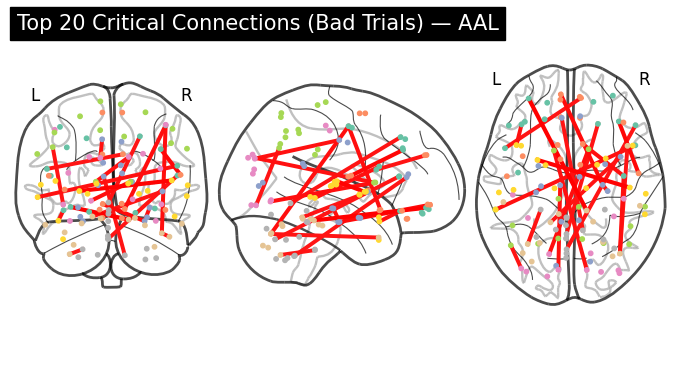

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2  # = 116*115/2 = 6670 total edges
top_k        = 20  # how many top edges to show

# Load the selected edge indices and accuracy per trial
selected_indices = np.load('selected_indices_aal(500t-tang).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-tang).npy')   # (num_trials,)

# Find all trials where accuracy is below the median (bad trials) as well as the bad indices
indices_matrix = selected_indices.T  # shape: (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)
bad_trials     = indices_matrix[accuracy_vector < median_acc]
bad_indices    = bad_trials.flatten() if bad_trials.size > 0 else np.array([], dtype=int)

# Count how often each edge appears in bad trials
freq_bad = np.bincount(bad_indices, minlength=num_features)

# Pick the top_k edges that appear most often in bad trials
top_bad_idx = np.argsort(freq_bad)[-top_k:][::-1]

# Helper to convert a flat edge index k to (i,j) in a n*n matrix
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        count = n - i - 1
        if k < total + count:
            j = i + 1 + (k - total)
            return i, j
        total += count
    raise ValueError("Index out of range.")

# Build a symmetric “frequency” matrix for those critical edges
matrix_critical = np.zeros((num_nodes, num_nodes))
for idx in top_bad_idx:
    i, j = index_to_coords(int(idx))
    matrix_critical[i, j] = freq_bad[idx]
    matrix_critical[j, i] = freq_bad[idx]

# Fetch AAL centroids for plotting
aal = fetch_atlas_aal()           
coords = plotting.find_parcellation_cut_coords(aal.maps)  # (116, 3)

# Plot only those critical connections on a glass brain
threshold = freq_bad[top_bad_idx[-1]]  # lowest frequency among the chosen edges
display = plotting.plot_connectome(
    matrix_critical,
    coords,
    edge_threshold=threshold,
    node_size=10,
    title=f"Top {top_k} Critical Connections (Bad Trials) — AAL"
)

plt.show()

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

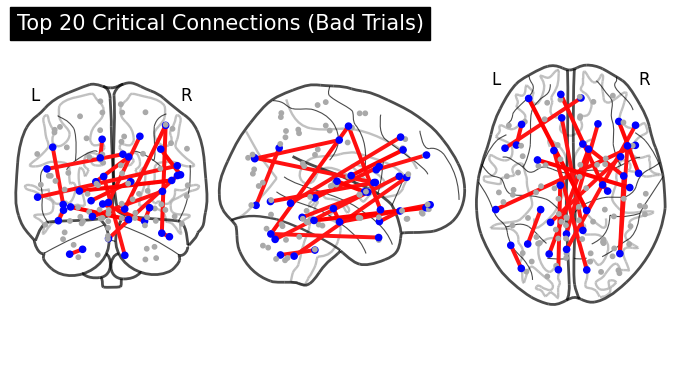

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

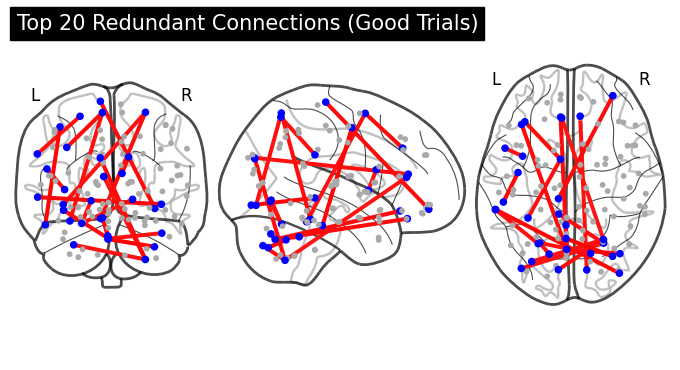

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20      # edges per category

# Load trial data
selected_indices = np.load('selected_indices_aal(500t-tang).npy')  # shape: (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-tang).npy')   # shape: (num_trials,)

# Prepare split by median accuracy
indices_matrix = selected_indices.T                 # (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)

# Bad trials / critical edges
bad_trials     = accuracy_vector < median_acc
bad_indices  = indices_matrix[bad_trials].flatten() if bad_trials.any() else np.array([], dtype=int)
freq_bad     = np.bincount(bad_indices, minlength=num_features)
top_bad_idx  = np.argsort(freq_bad)[-top_k:][::-1]

# Good trials / redundant edges
good_trials     = accuracy_vector >= median_acc
good_indices  = indices_matrix[good_trials].flatten() if good_trials.any() else np.array([], dtype=int)
freq_good     = np.bincount(good_indices, minlength=num_features)
top_good_idx  = np.argsort(freq_good)[-top_k:][::-1]

# Index→(i,j) helper for upper‐triangle of an n×n matrix
def index_to_coords(k, n=num_nodes):
    tot = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < tot + cnt:
            return i, i + 1 + (k - tot)
        tot += cnt
    raise ValueError(f"Index {k} out of range")

# Plotting helper
def plot_edges(edge_idx_list, freq_arr, title):
    # build full symmetric weight matrix
    M = np.zeros((num_nodes, num_nodes))
    connected = np.zeros(num_nodes, bool)
    for k in edge_idx_list:
        i, j = index_to_coords(int(k))
        M[i, j] = freq_arr[k]
        M[j, i] = freq_arr[k]
        connected[[i, j]] = True

    # node styling
    node_sizes  = [20 if c else 10 for c in connected]
    node_colors = ['blue' if c else 'darkgray' for c in connected]

    # fetch AAL centroids
    aal = fetch_atlas_aal()
    coords = plotting.find_parcellation_cut_coords(aal.maps)

    # edge threshold = smallest of the top‐K freqs
    thresh = float(freq_arr[edge_idx_list[-1]])
    plotting.plot_connectome(
        M, coords,
        edge_threshold=thresh,
        node_size=node_sizes,
        node_color=node_colors,
        title=title
    )
    plt.show()

# Visualize both panels
plot_edges(top_bad_idx,  freq_bad,  f"Top {top_k} Critical Connections (Bad Trials)")
plot_edges(top_good_idx, freq_good, f"Top {top_k} Redundant Connections (Good Trials)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

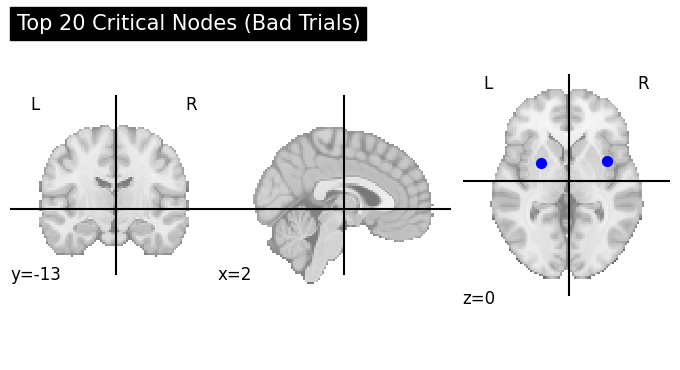

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

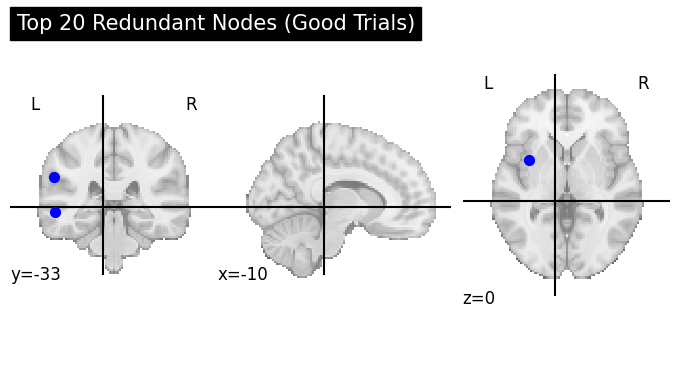

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20

# Load trial data
selected_indices = np.load('selected_indices_aal(500t-tang).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-tang).npy')   # (num_trials,)

# Prepare median split
indices_matrix = selected_indices.T                 # (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)

bad_trials  = indices_matrix[accuracy_vector < median_acc]
bad_indices = bad_trials.flatten() if bad_trials.size > 0 else np.array([], dtype=int)
freq_bad    = np.bincount(bad_indices, minlength=num_features)
top_bad_idx = np.argsort(freq_bad)[-top_k:][::-1]

good_trials  = indices_matrix[accuracy_vector >= median_acc]
good_indices = good_trials.flatten() if good_trials.size > 0 else np.array([], dtype=int)
freq_good    = np.bincount(good_indices, minlength=num_features)
top_good_idx = np.argsort(freq_good)[-top_k:][::-1]

#  Map 1D edge-index → (i, j) in the n×n matrix 
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        count = n - i - 1
        if k < total + count:
            return i, i + 1 + (k - total)
        total += count
    raise ValueError(f"Index {k} out of range for n={n}.")

# Plot nodes on ortho slices centered on their centroid
def plot_nodes_ortho(edge_idx_list, title):
    # 1. Flag which nodes are involved
    connected = np.zeros(num_nodes, dtype=bool)
    for idx in edge_idx_list:
        i, j = index_to_coords(int(idx))
        connected[i] = True
        connected[j] = True

    # 2. Fetch AAL centroids
    aal   = fetch_atlas_aal()
    coords = plotting.find_parcellation_cut_coords(aal.maps)

    # 3. Extract only the active-node coords
    coords_active = np.array([coords[i] for i, flag in enumerate(connected) if flag])
    if coords_active.size == 0:
        print(f"No nodes to plot for: {title}")
        return

    # 4. Compute mean center
    center = tuple(coords_active.mean(axis=0))

    # 5. Plot the anatomical slices
    display = plotting.plot_anat(
        title=title,
        display_mode='ortho',
        cut_coords=center
    )

    # 6. Overlay markers at each active centroid
    display.add_markers(
        coords_active.tolist(),
        marker_color='blue',
        marker_size=50
    )
    plt.show()

# Visualize critical vs. redundant nodes
plot_nodes_ortho(top_bad_idx,  f"Top {top_k} Critical Nodes (Bad Trials)")
plot_nodes_ortho(top_good_idx, f"Top {top_k} Redundant Nodes (Good Trials)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

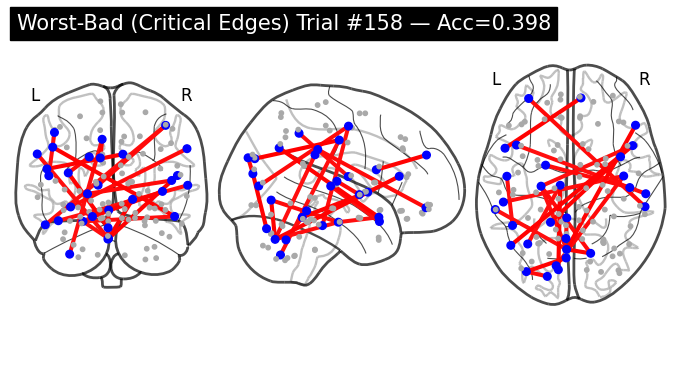

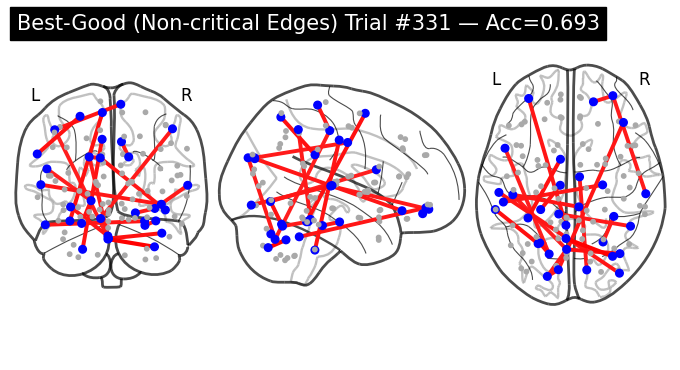

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Load your trial data 
selected_indices = np.load('selected_indices_aal(500t-tang).npy')  # shape: (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-tang).npy')   # shape: (num_trials,)

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20

#  Split by median accuracy
median_acc = np.median(accuracy_vector)
all_trials = np.arange(len(accuracy_vector))

bad_trials  = accuracy_vector < median_acc
good_trials = accuracy_vector >= median_acc

# Identify the single worst (lowest‐acc) bad trial and best (highest‐acc) good trial
bad_trials = all_trials[bad_trials]
best_bad   = bad_trials[np.argmin(accuracy_vector[bad_trials])] if bad_trials.size else None

good_trials = all_trials[good_trials]
best_good   = good_trials[np.argmax(accuracy_vector[good_trials])] if good_trials.size else None

# Precompute global edge frequencies over bad vs. good sets
indices_matrix = selected_indices.T  # (num_trials, num_selected)
freq_bad  = np.bincount(indices_matrix[bad_trials].flatten(),  minlength=num_features)
freq_good = np.bincount(indices_matrix[good_trials].flatten(), minlength=num_features)

# Helper: map 1D edge‐index → (i,j) in the upper triangle of an n×n matrix
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < total + cnt:
            return i, i + 1 + (k - total)
        total += cnt
    raise ValueError(f"Index {k} out of range for n={n}")

# Fetch AAL centroids once
aal    = fetch_atlas_aal()
coords  = plotting.find_parcellation_cut_coords(aal.maps)

def plot_top20(trial_idx, freq_array, label):
    if trial_idx is None:
        print(f"No {label} trials to plot.")
        return

    acc    = accuracy_vector[trial_idx]
    masked = selected_indices[:, trial_idx]   # which edges were zeroed in that trial

    # rank those edges by their overall freq, take top_k
    ranked = masked[np.argsort(freq_array[masked])[::-1]]
    top20   = ranked[:top_k]

    # build n×n adjacency with only those edges
    M = np.zeros((num_nodes, num_nodes))
    involved = np.zeros(num_nodes, bool)
    for k in top20:
        i, j = index_to_coords(int(k))
        M[i, j] = freq_array[int(k)]
        M[j, i] = freq_array[int(k)]
        involved[i] = True
        involved[j] = True

    # style nodes
    sizes  = [30 if involved[n] else 10 for n in range(num_nodes)]
    colors = ['blue' if involved[n] else 'darkgray' for n in range(num_nodes)]

    plotting.plot_connectome(
        M,
        coords,
        edge_threshold=min(freq_array[top20]),
        node_size=sizes,
        node_color=colors,
        title=f"{label} Trial #{trial_idx} — Acc={acc:.3f}"
    )
    plt.show()

# Plot the two panels
plot_top20(best_bad,  freq_bad,  "Worst-Bad (Critical Edges)")
plot_top20(best_good, freq_good, "Best-Good (Non-critical Edges)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

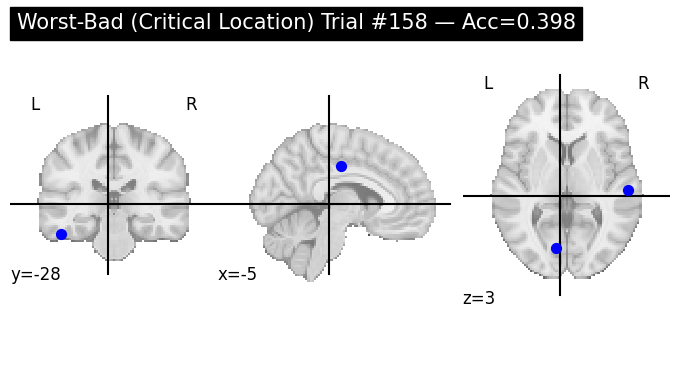

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

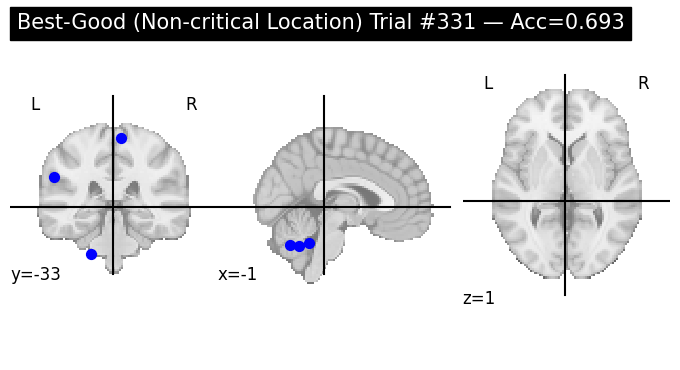

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Load your trial data
selected_indices = np.load('selected_indices_aal(500t-tang).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-tang).npy')   # (num_trials,)

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2   
top_k        = 20

# Split by median accuracy
median_acc = np.median(accuracy_vector)
all_trials = np.arange(len(accuracy_vector))

bad_trials  = accuracy_vector < median_acc
good_trials = accuracy_vector >= median_acc

bad_trials  = all_trials[bad_trials]
best_bad    = bad_trials[np.argmin(accuracy_vector[bad_trials])] \
                if bad_trials.size else None

good_trials = all_trials[good_trials]
best_good   = good_trials[np.argmax(accuracy_vector[good_trials])] \
                if good_trials.size else None

# Global edge‐frequency maps
indices_matrix = selected_indices.T  # (num_trials, num_selected)
freq_bad  = np.bincount(indices_matrix[bad_trials].flatten(),  minlength=num_features)
freq_good = np.bincount(indices_matrix[good_trials].flatten(), minlength=num_features)

#  Helper: map 1D edge‐index → (i,j) in n×n upper triangle
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < total + cnt:
            return i, i + 1 + (k - total)
        total += cnt
    raise ValueError(f"Index {k} out of range for n={n}")

# Ortho‐slice plotting for the top-20 edges of one trial
def plot_top20_ortho(trial_idx, freq_array, label):
    if trial_idx is None:
        print(f"No {label} trials to plot.")
        return
    acc    = accuracy_vector[trial_idx]
    masked = selected_indices[:, trial_idx]  # edges zeroed in this trial

    # rank this trial’s edges by their global freq, take top_k
    ranked = masked[np.argsort(freq_array[masked])[::-1]]
    top20   = ranked[:top_k]

    # mark which nodes get involved
    involved = np.zeros(num_nodes, dtype=bool)
    for k in top20:
        i, j = index_to_coords(int(k))
        involved[i] = True
        involved[j] = True

    # fetch AAL centroids
    aal   = fetch_atlas_aal()
    coords = plotting.find_parcellation_cut_coords(aal.maps)

    # select only the active-node coords
    coords_active = [coords[i] for i, flag in enumerate(involved) if flag]
    if not coords_active:
        print(f"No nodes to plot for {label} Trial #{trial_idx}")
        return

    # center the ortho view
    center = tuple(np.mean(coords_active, axis=0))

    # show the anatomy + markers
    display = plotting.plot_anat(
        title=f"{label} Trial #{trial_idx} — Acc={acc:.3f}",
        display_mode='ortho',
        cut_coords=center
    )
    display.add_markers(
        coords_active,
        marker_color='blue',
        marker_size=50
    )
    plt.show()

# Render both panels
plot_top20_ortho(best_bad,  freq_bad,  "Worst-Bad (Critical Location)")
plot_top20_ortho(best_good, freq_good, "Best-Good (Non-critical Location)")

In [1]:
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# Model definition
class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        self.gat1 = GATv2Conv(input_dim, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat3 = GATv2Conv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.3, edge_dim=1)
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        ew = edge_weight.view(-1, 1)
        x = F.relu(self.gat1(x, edge_index, ew))
        x = F.relu(self.gat2(x, edge_index, ew))
        x = self.gat3(x, edge_index, ew)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.fc(x))

# Train, validation, evaluation

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(out.squeeze(1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_graphs = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            loss = criterion(out.squeeze(1), data.y.float())
            total_loss += loss.item() * data.num_graphs
            total_graphs += data.num_graphs
    return total_loss / total_graphs

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

# Load data
x = np.load('./data/AAL_correlation_correlation.npy')
y = np.load('./data/Y.npy')
accuracy_vector = np.load("accuracy_vector_aal(500t-tang).npy")
selected_indices = np.load("selected_indices_aal(500t-tang).npy")

best_trial_index = np.argmax(accuracy_vector)
best_selected_indices = selected_indices[:, best_trial_index]

print("Best trial index:", best_trial_index)
print("Best accuracy:", accuracy_vector[best_trial_index])
# print("First 10 selected edge indices:", best_selected_indices[:10])

Best trial index: 331
Best accuracy: 0.6931818181818182


In [2]:
num_graphs, num_nodes, _ = x.shape
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

def generate_selected_graphs(X, y, selected_edge_indices):
    graphs = []
    for graph_idx in range(X.shape[0]):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]
        node_features = [[1.0] for _ in range(num_nodes)]
        edge_index = []
        edge_weight = []

        for idx in selected_edge_indices:
            i, j = edge_pairs[idx]
            weight = adjacency_matrix[i, j]
            if weight != 0:
                edge_index.append([i, j])
                edge_weight.append(weight)
                node_features[i][0] += weight
                node_features[j][0] += weight

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=label_tensor)
        graphs.append(data)
    return graphs

selected_graphs = generate_selected_graphs(x, y, best_selected_indices)

In [3]:
# 10-fold cross-validation with inner stratified split
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_accuracies = []

for fold, (train_val_idx, test_idx) in enumerate(skf.split(selected_graphs, y)):
    train_val_y = y[train_val_idx]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=fold)
    inner_train_idx, val_idx = next(sss.split(train_val_idx, train_val_y))
    train_idx = train_val_idx[inner_train_idx]
    val_idx = train_val_idx[val_idx]

    train_loader = DataLoader([selected_graphs[i] for i in train_idx], batch_size=32, shuffle=True)
    val_loader = DataLoader([selected_graphs[i] for i in val_idx], batch_size=32)
    test_loader = DataLoader([selected_graphs[i] for i in test_idx], batch_size=32)

    model = GraphAttentionModel(input_dim=1, hidden_dim=32, output_dim=16, heads=4)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

    for epoch in range(30):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss = eval_loss(model, val_loader, criterion)
        scheduler.step(val_loss)

    test_acc = evaluate(model, test_loader)
    test_accuracies.append(test_acc)
    print(f"Fold {fold+1}: Test Accuracy = {test_acc:.4f}")

mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
print(f"\nAverage Test Accuracy over 10 folds: {mean_acc:.4f} ± {std_acc:.4f}")

/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 1: Test Accuracy = 0.4659


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 2: Test Accuracy = 0.5287


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 3: Test Accuracy = 0.5287


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 4: Test Accuracy = 0.5517


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 5: Test Accuracy = 0.5172


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 6: Test Accuracy = 0.5402


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 7: Test Accuracy = 0.5402


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 8: Test Accuracy = 0.5402


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 9: Test Accuracy = 0.5402


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 10: Test Accuracy = 0.5402

Average Test Accuracy over 10 folds: 0.5293 ± 0.0229


In [4]:
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from sklearn.model_selection import StratifiedKFold

# Define model
class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        self.gat1 = GATv2Conv(input_dim, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat3 = GATv2Conv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.3, edge_dim=1)
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        ew = edge_weight.view(-1, 1)
        x = F.relu(self.gat1(x, edge_index, ew))
        x = F.relu(self.gat2(x, edge_index, ew))
        x = self.gat3(x, edge_index, ew)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return torch.sigmoid(x)

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(out.squeeze(1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation accuracy
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

# Load data
x = np.load('./data/AAL_correlation_correlation.npy')  # shape: (871, 116, 116)
y = np.load('./data/Y.npy')  # shape: (871,)

accuracy_vector = np.load("accuracy_vector_aal(500t-tang).npy")
selected_indices = np.load("selected_indices_aal(500t-tang).npy")

best_trial_index = np.argmax(accuracy_vector)
best_selected_indices = selected_indices[:, best_trial_index]

print("Best trial index:", best_trial_index)
print("Best accuracy:", accuracy_vector[best_trial_index])

num_graphs, num_nodes, _ = x.shape
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

# Generate graphs using only selected edges
def generate_selected_graphs(X, y, selected_edge_indices):
    graphs = []
    for graph_idx in range(X.shape[0]):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]
        node_features = [[1.0] for _ in range(num_nodes)]
        edge_index = []
        edge_weight = []

        for idx in selected_edge_indices:
            i, j = edge_pairs[idx]
            weight = adjacency_matrix[i, j]
            if weight != 0:
                edge_index.append([i, j])
                edge_weight.append(weight)
                node_features[i][0] += weight
                node_features[j][0] += weight

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=label_tensor)
        graphs.append(data)
    return graphs

# Generate graph data
selected_graphs = generate_selected_graphs(x, y, best_selected_indices)
graph_labels = y

# Cross-validation loop (stratified 10-fold)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(selected_graphs, graph_labels)):
    train_subset = [selected_graphs[i] for i in train_idx]
    test_subset = [selected_graphs[i] for i in test_idx]

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32)

    model = GraphAttentionModel(input_dim=1, hidden_dim=32, output_dim=16, heads=4)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train for 30 epochs
    for epoch in range(30):
        train_loss = train(model, train_loader, optimizer, criterion)

    test_acc = evaluate(model, test_loader)
    test_accuracies.append(test_acc)
    print(f"Fold {fold+1}: Test Accuracy = {test_acc:.4f}")

# Final mean and std
mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
print(f"\nAverage Test Accuracy over 10 folds: {mean_acc:.4f} ± {std_acc:.4f}")

Best trial index: 331
Best accuracy: 0.6931818181818182


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Accuracy = 0.5227
Fold 2: Test Accuracy = 0.5517
Fold 3: Test Accuracy = 0.5287
Fold 4: Test Accuracy = 0.5402
Fold 5: Test Accuracy = 0.5402
Fold 6: Test Accuracy = 0.5287
Fold 7: Test Accuracy = 0.5402
Fold 8: Test Accuracy = 0.5402
Fold 9: Test Accuracy = 0.5402
Fold 10: Test Accuracy = 0.5402

Average Test Accuracy over 10 folds: 0.5373 ± 0.0079
